#### **imports**

In [1]:
import pickle
import sys
from collections import Counter
from collections import OrderedDict
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict
from collections import Counter
import shap

# Set the random seed
np.random.seed(123)
random_state = 123

# Clustering
from sklearn.cluster import KMeans

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### **Load Data**

In [2]:
# Read the pickled DataFrames
with open('data/x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open('data/x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open('data/x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open('data/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('data/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open('data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl_tv.pickle', 'rb') as file:
    consolidated_pat_tbl_tv = pickle.load(file)

#### **Survival Prediction**

In [3]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()
    

    def c_index_lbo_loss(self , logits , times , events):
        '''
        here logits are used to form the predicted survival times
        '''
        _haz = torch.sigmoid(logits)
        _survival = torch.cumprod(1 - _haz , dim = 1)

        # get last survival proba    
        last_pred_survival = _survival[: , -1]
            
        # get comparable mask
        comp_mask = self.get_comparable_mask(times , events)
            
        # get loss - in order to maximise the LBO of the C-index, its negative needs to be minimized
        loss = -self.cindex_lower_bound(comp_mask , last_pred_survival , times)

        return loss

    def cindex_lower_bound(self , comp_mask, pred_times, times):
        '''
        comp_mask - comparable mask (no need for times and events separately)
        pred_times - predicted survival times / (or survival probabilities)
        '''
        # Get order
        _, order = torch.sort(times)
        
        # Convert comp_mask and pred_times to PyTorch tensors - hen order accordingly
        pred_times_tensor = pred_times[order]

        # Lower Bound
        lb = torch.sum(comp_mask * (1 + torch.log(torch.sigmoid(pred_times_tensor - pred_times_tensor.view(-1, 1))) / torch.log(torch.tensor(2)))) / torch.sum(comp_mask)
            
        # Exact C index
        cindex = torch.sum(comp_mask * (pred_times_tensor - pred_times_tensor.view(-1, 1)) > 0) / torch.sum(comp_mask)
        # print(lb , cindex)
        assert lb <= cindex, 'not a lower bound'

        # add gradient tracking
        lb = lb.clone().detach().requires_grad_(True)
            
        return lb

    def get_comparable_mask(self , times, events):
        # Get order
        _, order = torch.sort(times)
        eve_ordered = events[order]

        # Build cross matrix
        cross_mat = torch.triu((torch.outer(eve_ordered, eve_ordered) + eve_ordered.view(-1, 1)).bool()).int()
        
        # Set all diagonal elements to zero
        cross_mat.fill_diagonal_(0)

        return cross_mat

In [4]:
class Net(nn.Module):
    def __init__(self , fc_input_size, hidden_size , output_size , dropout_rate = 0.1):
        super(Net , self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 14, kernel_size = 3 , stride = 1 , padding = 1) , nn.ReLU() , 
            nn.Conv2d(14, 7, kernel_size = 3 , stride = 1 , padding = 1) , nn.ReLU() ,
            nn.Flatten()
        )
        
        # self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.fc(self.conv_net(torch.Tensor(x).to(torch.float32)))
        return output

In [15]:
class MyDataset_MLP(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, duration_index , durations, events):
        self.data = features
        self.durations = durations
        self.duration_index = duration_index
        self.events = events
        assert self.data.shape[0] == self.duration_index.shape[0] == self.durations.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur_idx = self.duration_index[index] # duration index
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur_idx , dur , eve

In [6]:
class Surv_Matrix:
    def __init__(self , duration_index , events , q_cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [7]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [8]:
q_cuts = 15 # number of discretized durations

# Prepare val and test data
get_target = lambda df: (df['time_to_event'].values, df['death'].values)

y_train_dur , y_train_event = get_target(y_train)

y_test_dur , y_test_event = get_target(y_test)
t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

In [26]:
# input_size = num_principal_components
input_size = 7*x_train_reshape_tv.shape[2]*x_train_reshape_tv.shape[3]
print(input_size)
hidden_size = 32
output_size = t_test.n_duration_index

# Create a data loader for batching and shuffling
batch_size = 512
num_epochs = 120
learning_rate = 0.001
shuffle = True
patience = 20
dropout = 0.5
alpha = 0.05

# build net
net = Net(input_size , hidden_size , output_size , dropout_rate = dropout)
# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

6300


In [27]:
# init loss
l = generic_Loss()

# init loss for early stopping
best_loss = np.Inf

# get features
features = x_train_reshape_tv

# get death time and event indicator
y_train_dur , y_train_event = get_target(y_train)

t_train = Transforms(durations = y_train_dur)
dur_idx = t_train.discrete_transform(_cuts = q_cuts)
    
# Create an instance of your custom dataset
dataset = MyDataset_MLP(features, dur_idx , y_train_dur , y_train_event) # need to change outcomes[0] to indexed version
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
# Training loop
for epoch in range(num_epochs):
    for batch_id , (patient_image , dur_idx , dur , eve) in enumerate(dataloader):
        # Prime for training
        net.train()
            
        # forward pass
        phi_train = net(patient_image)

        # make survival matrix
        sm = Surv_Matrix(duration_index = dur_idx, events = eve , q_cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()           

        # get loss
        loss_1 = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur_idx)
        loss_2 = l.c_index_lbo_loss(logits = phi_train , times = dur , events = eve)
        
        # combine
        loss = alpha*loss_1 + (1-alpha)*(loss_2)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # Early stopping
        with torch.no_grad():
            # get duration, event
            y_val_dur , y_val_event = get_target(y_val)
                
            # transform to discrete
            t_val = Transforms(durations = y_val_dur)
            dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)
                
            # build surv matrix for val data
            sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = q_cuts)
            surv_mat_val = sm_val.make_survival_matrix()
                
            # compute loss
            phi_val = net(torch.Tensor(x_val_reshape_tv))
            val_loss_1 = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
            val_loss_2 = l.c_index_lbo_loss(logits = phi_val , times = torch.Tensor(y_val_dur) , events = torch.Tensor(y_val_event))

            # combine
            val_loss = alpha*val_loss_1 + (1-alpha)*(val_loss_2)

        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break

    if (epoch%50==0): print(f'''Epoch {epoch}: Training Loss: {loss.item():.4f} , Val loss: {val_loss.item():.4f}''') 

Epoch 0: Training Loss: 0.1500 , Val loss: 0.1548
Epoch 50: Training Loss: 0.0471 , Val loss: 0.0583
Epoch 100: Training Loss: 0.0477 , Val loss: 0.0550


**Testing**

In [28]:
# Testing
surv = [] # length will be equal to number of cluster
mc_iter = 100

# get features, death time and event indicator
features = torch.Tensor(x_test_reshape_tv)
    
# get death time and event indicator
y_test_dur , y_test_event = get_target(y_test)

surv = []

# apply Monte Carlo dropout
for _ in range(mc_iter):
        
    # Prime dropout layers
    net.train()
        
    # predict
    mc_haz = torch.sigmoid(net(features))
    mc_survival = torch.log(1 - mc_haz).cumsum(1).exp().detach().numpy()

    # append survivals from different runs
    surv.append(mc_survival)
    
# convert to 3d array
surv = np.array(surv)

# get stats
mean_ = np.mean(surv , axis = 0)
up_ = np.quantile(surv , axis = 0 , q = 0.95)
low_ = np.quantile(surv , axis = 0 , q = 0.05)

# QCs
assert mean_.shape[0] == up_.shape[0] == low_.shape[0] == y_test_dur.shape[0] == y_test_event.shape[0] , 'shape mismatch'

In [29]:
def plot_with_cf(mean_ , low_ , up_ , _from , _to = None):
    if _to is not None:
        for _ , (m , l , u) in enumerate(zip(mean_[_from:_to] , low_[_from:_to] , up_[_from:_to])):
            plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean');
            plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.01 , label = 'confint');
    else:
        m , l , u = mean_[_from] , low_[_from] , up_[_from]
        plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean');
        plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.01 , label = 'confint');

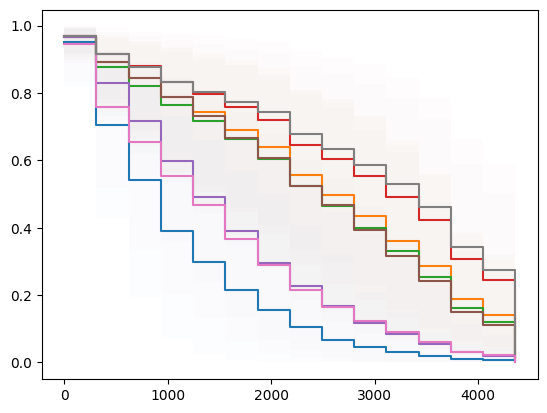

In [30]:
plot_with_cf(mean_ , low_ , up_ , _from = 2 , _to = 10)

shapes : (1180, 1180, 1180, 1180)
concordance-td: 0.7070434842112466
integrated brier score 0.45561914850713714


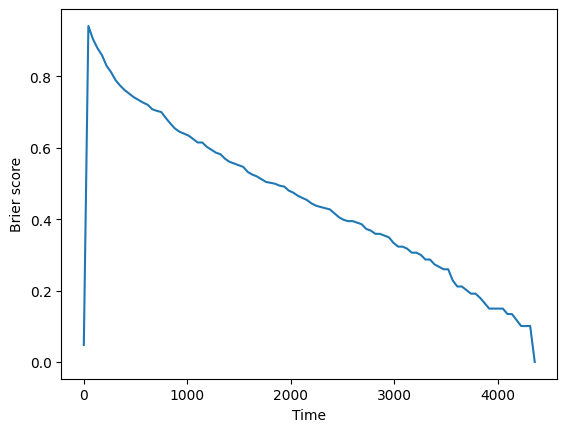

In [31]:
# Evaluation

ev_ = EvalSurv(pd.DataFrame(mean_.T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')

time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')

-----------------

## **JUNK**

In [ ]:
# def make_tensor_3d(array_of_tensors):
#     num_tensors = len(array_of_tensors)
#     rows, columns = array_of_tensors[0].shape

#     resulting_3d_tensor = torch.zeros((num_tensors, rows, columns))

#     for i, tensor in enumerate(array_of_tensors):
#         resulting_3d_tensor[i, :, :] = tensor
    
#     return resulting_3d_tensor

# x_train_reshape_tv = make_tensor_3d(x_train_reshape_tv)
# x_test_reshape_tv = make_tensor_3d(x_test_reshape_tv)
# x_val_reshape_tv = make_tensor_3d(x_val_reshape_tv)

# # Reshape
# def reshape_df(tensor):
#     return tensor.view(tensor.shape[0] , 1 , tensor.shape[1] , tensor.shape[2])

# x_train_reshape_tv = reshape_df(x_train_reshape_tv)
# x_test_reshape_tv = reshape_df(x_test_reshape_tv)
# x_val_reshape_tv = reshape_df(x_val_reshape_tv)

In [ ]:
# # Define the RNN Autoencoder model
# class RNN_AE(nn.Module):
#     def __init__(self, input_size, hidden_size, bottleneck_size):
#         super(RNN_AE, self).__init__()
#         self.hidden_size = hidden_size
        
#         # RNN Encoder
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
#         # Bottleneck layer
#         self.encoder = nn.Linear(hidden_size, bottleneck_size)
        
#         # Autoencoder Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(bottleneck_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, input_size)
#         )

#     def forward(self, x):
#         # RNN Encoder
#         rnn_output, _ = self.rnn(x)
        
#         # Bottleneck Layer
#         encoded_output = self.encoder(rnn_output)
        
#         # Autoencoder Decoder
#         decoded_output = self.decoder(encoded_output)
        
#         return encoded_output , decoded_output

In [ ]:
# input_size = 91
# hidden_size = 100
# bottleneck_size = 46

# # Model Initialization
# model = RNN_AE(input_size, hidden_size, bottleneck_size)
 
# # Validation using MSE Loss function
# loss_function = torch.nn.MSELoss()
 
# # Using an Adam Optimizer with lr = 0.1
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr = 1e-1,
#                              weight_decay = 1e-8)

In [ ]:
# enc , dec = model(torch.Tensor(x_train_reshape_tv[1000]))
# enc.shape , dec.shape

In [ ]:
# # # %%time

# # # # def get_spca(L , M , k):
# # # #     # normalize
# # # #     L_ = L/np.linalg.norm(L , axis = 0)
# # # #     M_ = M/np.linalg.norm(M , axis = 0)
# # # #     # get spca
# # # #     s_pca = np.trace(L_@M_.T@M_@L_.T)/k
# # # #     return s_pca

# # # # pca_transforms = []
# # # # n_components = 1

# # # # for idx , x in enumerate(x_train_reshape_tv):
# # # #     pca = PCA(n_components = n_components , svd_solver = 'arpack') # encourage sparse solutions
# # # #     pca_transform_x = pca.fit_transform(x)
# # # #     # store in list
# # # #     pca_transforms.append(pca_transform_x)
# # # # # form an array (optional)
# # # # pca_transforms_arr = np.array(pca_transforms , dtype = 'object')

# # # # assert len(pca_transforms_arr) == len(x_train_reshape_tv) , 'lengths must match'

# # # # # Create a square distance matrix
# # # # distance_matrix = np.zeros((len(pca_transforms_arr) , len(pca_transforms_arr)))

# # # # for i in range(len(pca_transforms_arr)):
# # # #     for j in range(i , len(pca_transforms_arr)):
# # # #         distance_matrix[i,j] = get_spca(L = pca_transforms_arr[i] , M = pca_transforms_arr[j] , k = n_components)
# # # #         distance_matrix[j,i] = distance_matrix[i,j]

# # # # L = np.random.randn(3,3)
# # # # M = np.random.randn(40,3)
# # # # get_spca(L , M , 5)
# # # pca.components_

# # import pickle
# # # Pickle the DataFrame
# # with open('data/distance_matrix_train_.pickle', 'wb') as file:
# #     pickle.dump(distance_matrix, file)
# # Read the pickled DataFrames
# with open('data/distance_matrix_train_.pickle', 'rb') as file:
#     distance_matrix_train_ = pickle.load(file)

In [ ]:
class MLP(nn.Module):
#     def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
#         super(MLP , self).__init__()

#         # Define the dimensions of the RNN
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size

#         self.rnn = nn.RNN(self.input_size, self.hidden_size, batch_first=True)
        
#         # Feed-forward nn
#         self.fc = nn.Sequential( 
#             nn.BatchNorm1d(hidden_size), 
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size , hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, output_size)
#         )

#     def forward(self, x):
#         # Initialize the hidden state
#         h0 = torch.zeros(1, x.size(0), self.hidden_size)#.to(x.device)

#         # Forward pass through the RNN layer
#         out, _ = self.rnn(x, h0)
        
#         # Get the output from the last time step
#         out = self.fc(out[:, -1, :])

#         return out